# Evaluating performances of a model in a coverage plot
In this part of the lesson we are going to see how we can evaluate performances of a trained model using a coverage plot. The dataset that will be used is the Scikit Learn's breast cancer.

## General imports
Import the needed libraries. We are going to use a LogisticRegression classifier to fit the data.

In [2]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Loading datasets
The first thing to do is to load the dataset. Sklearn has already a lots of datasets available. Each dataset comes with a custom utility function to load the dataset. In this case we are using the custom function of the `breast_cancer` dataset to load it.
The `X` variable is going to contain the *istances* of the dataset, while the `y` variable contains the *labels* (the outcome - `false | positive` - associated with the data)

In [3]:
X,y = load_breast_cancer(return_X_y=True)

Before training the model we need to split the dataset between 2 subsets: $Te$ and $Tr$.  
The `train_test_split` function is used here to take $33$% of the dataset to be $Te$, while the remaining to be $Tr$. The `random_state` parameter is a RNG seed used to avoid sampling the istances too uniformly. 
The seed is configurable since we need our experiments to be reproducible.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Compute $Te^{\oplus}$ and $Te^{\ominus}$

In [5]:
Pos = sum(y_test == 1)
Neg = sum(y_test == 0)

print(Pos, Neg)

121 67


# Fitting the data

Now we need to fit the data using the `LogisticRegression` classifier.
First, we need to create the actual classifier, by passing the maximum number of iterations needed by its learning algorithm. Then we train the data on the $Tr$ dataset with its appropriate `fit` function.

In [6]:
lr = LogisticRegression(max_iter = 100)
lr.fit(X_train, y_train)

/nix/store/v2ig8phm4zm423iwjjdkssmmk9j7vg3b-python3-3.8.9-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Making predictions
At this point `lr` is a trained classifier and we can make predictions using it.
The method `predict_proba` returns the probability of each class guessed by the classifier.
Since `predict_proba` returns a $|Te|\times2$ matrix, we are only interested in a vector of probabilities concerning the second element of the vector (which corresponds to the probability of the istance to be in the second class)

In [7]:
probs = lr.predict_proba(X_test)[:, 1]

## Evaluating FP, TP and accuracy
Here we define some functions to compute common indicators such as *true/false positives* and *accuracy*

In [8]:
# Given two vectors containing true labels and predicted labels, compute true positives and false positives
def eval_fp_tp(actual, predicted):
    tp = np.logical_and(predicted, actual)
    fp = np.logical_and(predicted, np.logical_not(actual))
    return (sum(fp), sum(tp))

In [9]:
# Define the function to calculate the accuracy
def eval_accuracy(actual, predicted):
    fp, tp = eval_fp_tp(actual, predicted)
    return (tp + (Neg - fp)) / len(actual)

## fp,tp and accuracy evaluations for different thresholds

Given the scores for the test cases, we might want to find the best possible threshold for classification, i.e., the real value $t$ such that `scores >` $t$ gives the best classification of the examples. 

Let us then start to consider 100 possible thresholds in the range $[0,1]$:

In [10]:
# This is the same as
# [i/100 | i <- [0..100]]
thresholds = [i/100.0 for i in range(0,100)]

and compute the tp, fp, and accuracy values of the labelings obtained by comparing the scores with those thresholds.

In [11]:
fps, tps, performances = [], [], []
accuracy = 0

for t in thresholds:
    predicted_pos = probs > t
    fp, tp = eval_fp_tp(y_test, predicted_pos)
    fps.append(fp)
    tps.append(tp)
    accuracy = eval_accuracy(y_test, predicted_pos)
    performances.append((accuracy, t, fp, tp))
performances = np.array(performances)

# Plotting

Let us then start plotting the coverage plot for the obtained classifications.

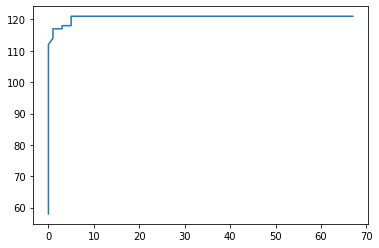

In [12]:
plt.plot(fps, tps)

# Checking performances for threshold 0.5

The predict_proba method we used to get the score returns the probability that examples belong to the positive class. Usually the positive class is then predicted as score > 0.5 (since in this case it is the one with the largest likelihood).

Let's then see where this classifier (i.e., the one obtained setting the threshold to 0.5) lays in the coverage plot and if there are better options.

**note**: since we saved interesting stats in the `performances` array, we can retrieve the fp, tp position of the classifier we get by setting the thresholds to 0.5, by finding the position of the row we are interested using the expression: `performances[:,1] == 0.5` and then using the resulting boolean vector to retrieve the correct row of the matrix: `performances[performances[:,1] == 0.5]`.

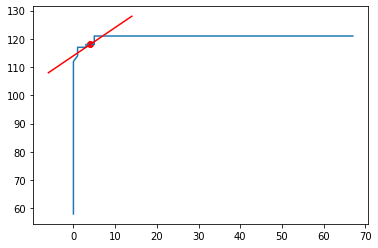

In [55]:
plt.plot(fps, tps)
accuracy, threshold, fp, tp = performances[performances[:,1] == 0.5][0]
plt.scatter(fp,tp,color='red')
plt.plot([fp-10,fp+10],[tp-10,tp+10], color="red")

As it is shown by the red dot and the red line, threshold 0.5 is a good one, but apparently two other points can reach a better classification.

Let us see where these point lay in the plot and what is their accuracy.

In [57]:
# Note: the subscription returns a matrix with a single row, but still two dimensions, 
# we need to get the element in the first position of that matrix...

perf05 = performances[performances[:, 1] == 0.5][0,0] 
performances[performances[:,0] > perf05]

array([[9.68085106e-01, 8.00000000e-02, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 9.00000000e-02, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.00000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.10000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.20000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.30000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.40000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.50000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 1.60000000e-01, 6.00000000e+00, 1.21000000e+02],
       [9.73404255e-01, 1.70000000e-01, 5.00000000e+00, 1.21000000e+02],
       [9.73404255e-01, 1.80000000e-01, 5.00000000e+00, 1.21000000e+02],
       [9.73404255e-01, 1.90000000e-01, 5.00000000e+00, 1.21000000e+02],
       [9.68085106e-01, 2.00000000e-01, 5.00000000e+00, 1.20000000e+02],
       [9.68085106e-01, 2.10000000e-01, 5.00000000e

The two points that we are looking for are then in position (5,121) and (1,117), since they are the points associated with the maximum accuracy

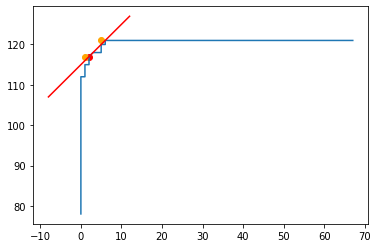

In [36]:
plt.plot(fps, tps)
fp, tp = eval_fp_tp(y_test, probs > 0.5)
plt.scatter(fp,tp, color="red")
plt.scatter(5,121, color="orange")
plt.scatter(1,117, color="orange")
plt.plot([fp-10,fp+10],[tp-10,tp+10], color="red")

These two points (that we found by looking only to the accuracies) are indeed the two points that the plot show having a better accuracy. 